<a href="https://colab.research.google.com/github/Thiru2208/CM2607_CW/blob/main/WeatherPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

df = pd.read_csv("/content/weatherData.csv")
df = df[df['location_id'].isin([0,1,2])].copy()

columns_to_drop = ['apparent_temperature_max (°C)',
                   'apparent_temperature_min (°C)',
                   'apparent_temperature_mean (°C)',
                   'daylight_duration (s)',
                   'sunshine_duration (s)',
                   'precipitation_sum (mm)',
                   'precipitation_hours (h)',
                   'sunrise',
                   'sunset'
]

df.drop(columns = [c for c in columns_to_drop if c in df.columns], inplace=True)

In [3]:
df["date"] = pd.to_datetime(df["date"], errors= "coerce")
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year
df["day_of_week"] = df["date"].dt.dayofweek

def get_season(month):
  if month in [12, 1, 2]:
    return "Northeast Monsoon"
  elif month in [3, 4, 5]:
    return "First Inter-monsoon"
  elif month in [6, 7, 8, 9]:
    return "Southwest Monsoon"
  else:
    return "Second Inter-monsoon"

df["season"] = df["month"].apply(get_season)

In [4]:
df["temperature_range (°C)"] = df["temperature_2m_max (°C)"] - df["temperature_2m_min (°C)"]
df["avg_temp (°C)"] = df[["temperature_2m_max (°C)", "temperature_2m_min (°C)"]].mean(axis=1)

In [5]:
df["is_rainy"] = (df["rain_sum (mm)"]>0).astype(int)

def categorize_rainfall(rain):
  if rain == 0:
    return "no rain"
  elif rain < 5:
    return "light rain"
  elif rain <20:
    return "moderate rain"
  else:
    return "heavy rain"

df["rain_intensity_category"] = df["rain_sum (mm)"].apply(categorize_rainfall)

df = df.sort_values (["location_id", "date"]).copy()
df["rain_lag1 (mm)"] = df.groupby("location_id")["rain_sum (mm)"].shift(1)
df["rain_role3_mean (mm)"] = (
    df.groupby("location_id")["rain_sum (mm)"]
    .transform(lambda s: s.rolling(window=3, min_periods=1).mean())
)

In [6]:
import numpy as np

rad = df["shortwave_radiation_sum (MJ/m²)"]
et0 = df["et0_fao_evapotranspiration (mm)"]
df["radiation_to_et_ratio"] = np.where(
                              et0 == 0,
                              np.nan,
                              rad / et0)

speed = df["wind_speed_10m_max (km/h)"]
gust = df["wind_gusts_10m_max (km/h)"]
df["wind_strength_index"] = np.where(gust ==0,
                                     np.nan,
                                     speed / gust)

In [7]:
df.to_csv("/content/weatherData_featured.csv", index=False)
print("Feature engineering completed and saved as weatherData_featured.csv")

Feature engineering completed and saved as weatherData_featured.csv


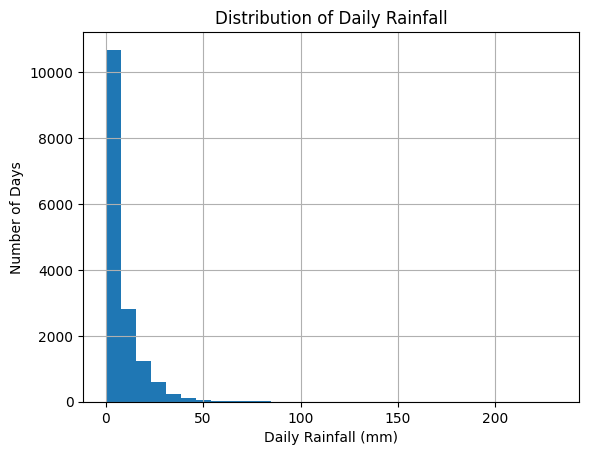

In [8]:
import matplotlib.pyplot as plt
plt.figure()
df["rain_sum (mm)"].hist(bins=30)
plt.xlabel("Daily Rainfall (mm)")
plt.ylabel("Number of Days")
plt.title("Distribution of Daily Rainfall")
plt.show()



Average rainfall by season:
 season
Northeast Monsoon        4.055329
First Inter-monsoon      7.093792
Southwest Monsoon        8.319153
Second Inter-monsoon    12.270258
Name: rain_sum (mm), dtype: float64


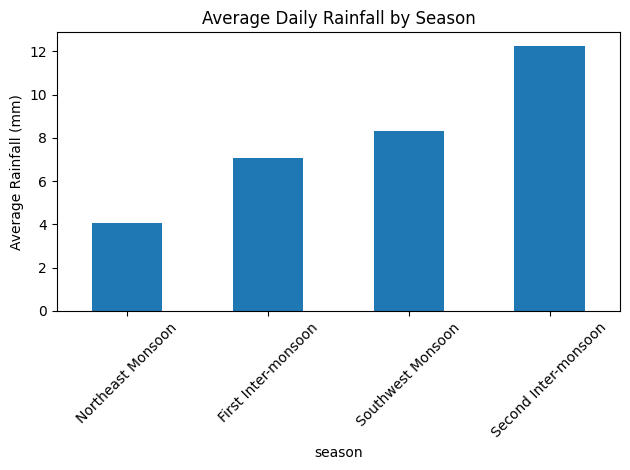

In [9]:
season_rain = df.groupby("season")["rain_sum (mm)"].mean().sort_values()

print("\nAverage rainfall by season:\n", season_rain)

plt.figure()
season_rain.plot(kind="bar")
plt.ylabel("Average Rainfall (mm)")
plt.title("Average Daily Rainfall by Season")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Rainy vs Non-rainy days:
 is_rainy
0     1753
1    14066
Name: count, dtype: int64


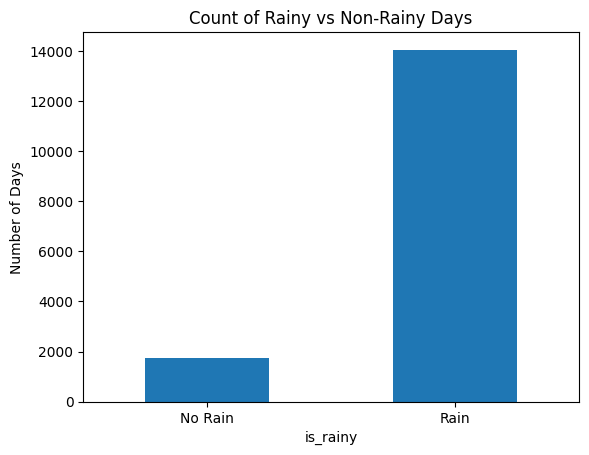

In [10]:
rain_counts = df["is_rainy"].value_counts().sort_index()
print("\nRainy vs Non-rainy days:\n", rain_counts)

plt.figure()
rain_counts.plot(kind="bar")
plt.xticks([0, 1], ["No Rain", "Rain"], rotation=0)
plt.ylabel("Number of Days")
plt.title("Count of Rainy vs Non-Rainy Days")
plt.show()



Rainfall intensity counts:
 rain_intensity_category
light rain       7092
moderate rain    5454
no rain          1753
heavy rain       1520
Name: count, dtype: int64


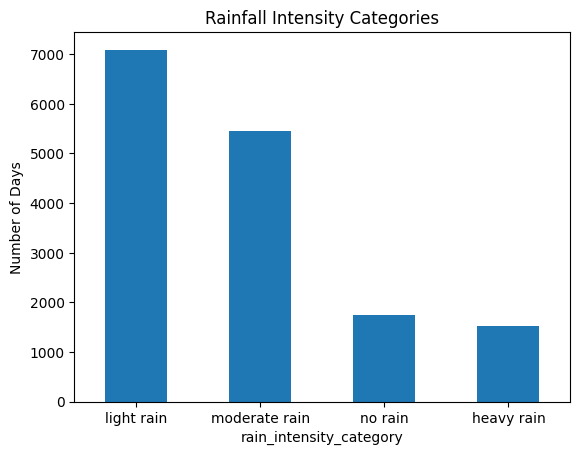

In [11]:
intensity_counts = df["rain_intensity_category"].value_counts()

print("\nRainfall intensity counts:\n", intensity_counts)

plt.figure()
intensity_counts.plot(kind="bar")
plt.ylabel("Number of Days")
plt.title("Rainfall Intensity Categories")
plt.xticks(rotation=0)
plt.show()


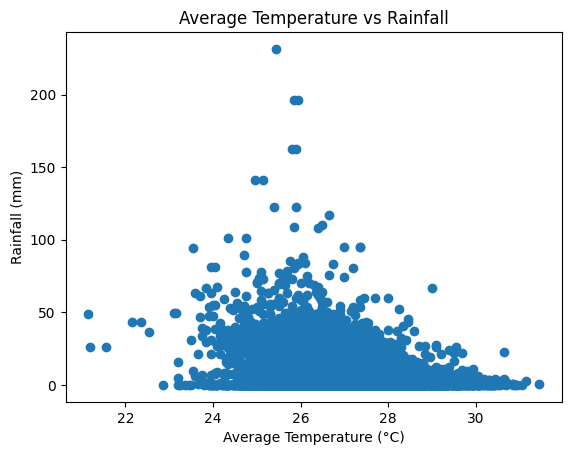

In [12]:
plt.figure()
plt.scatter(df["avg_temp (°C)"], df["rain_sum (mm)"])
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Rainfall (mm)")
plt.title("Average Temperature vs Rainfall")
plt.show()


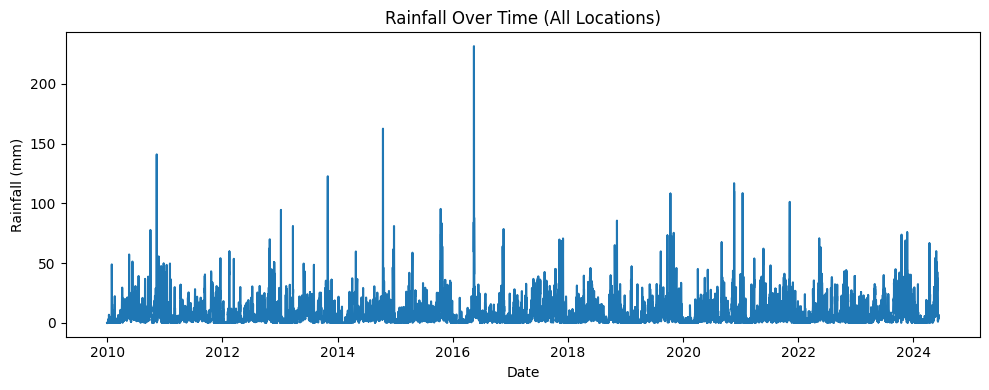

In [13]:
# Sort by date for proper time series
df_sorted = df.sort_values("date")

plt.figure(figsize=(10,4))
plt.plot(df_sorted["date"], df_sorted["rain_sum (mm)"])
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.title("Rainfall Over Time (All Locations)")
plt.tight_layout()
plt.show()


Location id 0 means colombo

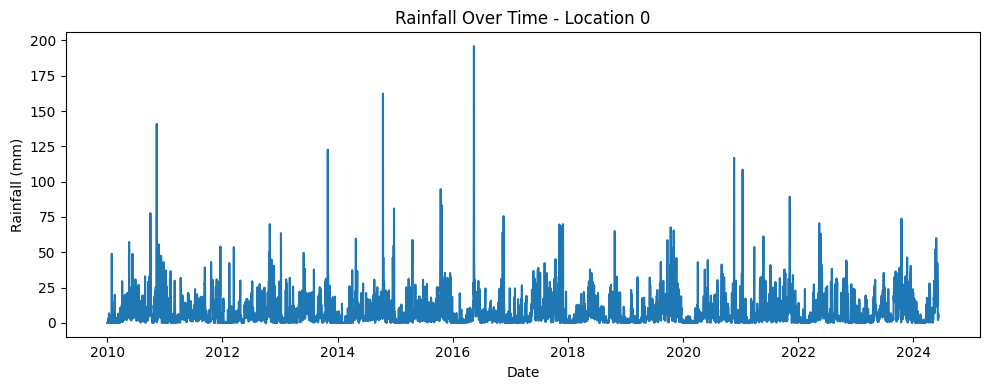

In [14]:
loc_id = 0
df_loc = df_sorted[df_sorted["location_id"] == loc_id]

plt.figure(figsize=(10,4))
plt.plot(df_loc["date"], df_loc["rain_sum (mm)"])
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.title(f"Rainfall Over Time - Location {loc_id}")
plt.tight_layout()
plt.show()
